In [1]:
import tensorflow as tf
import keras 
from keras.layers import Conv2D , MaxPooling2D
from keras import backend as k
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold



In [2]:
df = pd.read_csv(r"C:\Users\MinhThw\OneDrive\Desktop\DATN\data\hyper.csv", sep=";")

In [3]:

df['Hypertension'] = df['Hypertension'].map({'Normal': 0, 'Prehypertension': 1, 'Stage 1 hypertension': 2,'Stage 2 hypertension':3})
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['BMI'] = pd.to_numeric(df['BMI'].str.replace(',', '.'), errors='coerce')
df['Diabetes'] = df['Diabetes'].map(lambda x: 0 if pd.isna(x) else 1)
df['CI'] = df['Cerebral Infarction'].map(lambda x: 0 if pd.isna(x) else 1)
df['CD'] = df['Cerebrovascular Disease'].map(lambda x: 0 if pd.isna(x) else 1)
df['SBP'] = df['Systolic Blood Pressure']
df['DBP'] = df['Diastolic Blood Pressure']
df = df.drop(['Num', 'Subject_ID','Cerebral Infarction', 'Cerebrovascular Disease', 'Diastolic Blood Pressure', 'Systolic Blood Pressure'], axis =1)

In [4]:
print (df)

     Sex  Age  Height  Weight  Heart Rate        BMI  Diabetes  Hypertension  \
0      0   45     152      63          97  27.268006         0             3   
1      0   50     157      50          76  20.284799         0             3   
2      0   47     150      47          79  20.888889         0             0   
3      1   45     172      65          87  21.971336         0             1   
4      0   46     155      65          73  27.055151         0             1   
..   ...  ...     ...     ...         ...        ...       ...           ...   
214    1   24     180      70          77  21.604938         0             0   
215    0   25     156      47          79  19.312952         0             0   
216    1   25     176      55          72  17.755682         0             1   
217    1   25     173      63          67  21.049818         0             0   
218    1   24     175      58          65  18.938776         0             0   

     CI  CD  SBP  DBP  
0     0   0  16

In [5]:
# Kiểm tra thông tin cơ bản về dữ liệu
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sex           219 non-null    int64  
 1   Age           219 non-null    int64  
 2   Height        219 non-null    int64  
 3   Weight        219 non-null    int64  
 4   Heart Rate    219 non-null    int64  
 5   BMI           219 non-null    float64
 6   Diabetes      219 non-null    int64  
 7   Hypertension  219 non-null    int64  
 8   CI            219 non-null    int64  
 9   CD            219 non-null    int64  
 10  SBP           219 non-null    int64  
 11  DBP           219 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 20.7 KB
None
              Sex         Age      Height      Weight  Heart Rate         BMI  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.474886   57.168950  161.228311   60.191781   73.639269   23.107

In [6]:
# Kiểm tra các giá trị bị thiếu
print(df.isnull().sum())

Sex             0
Age             0
Height          0
Weight          0
Heart Rate      0
BMI             0
Diabetes        0
Hypertension    0
CI              0
CD              0
SBP             0
DBP             0
dtype: int64


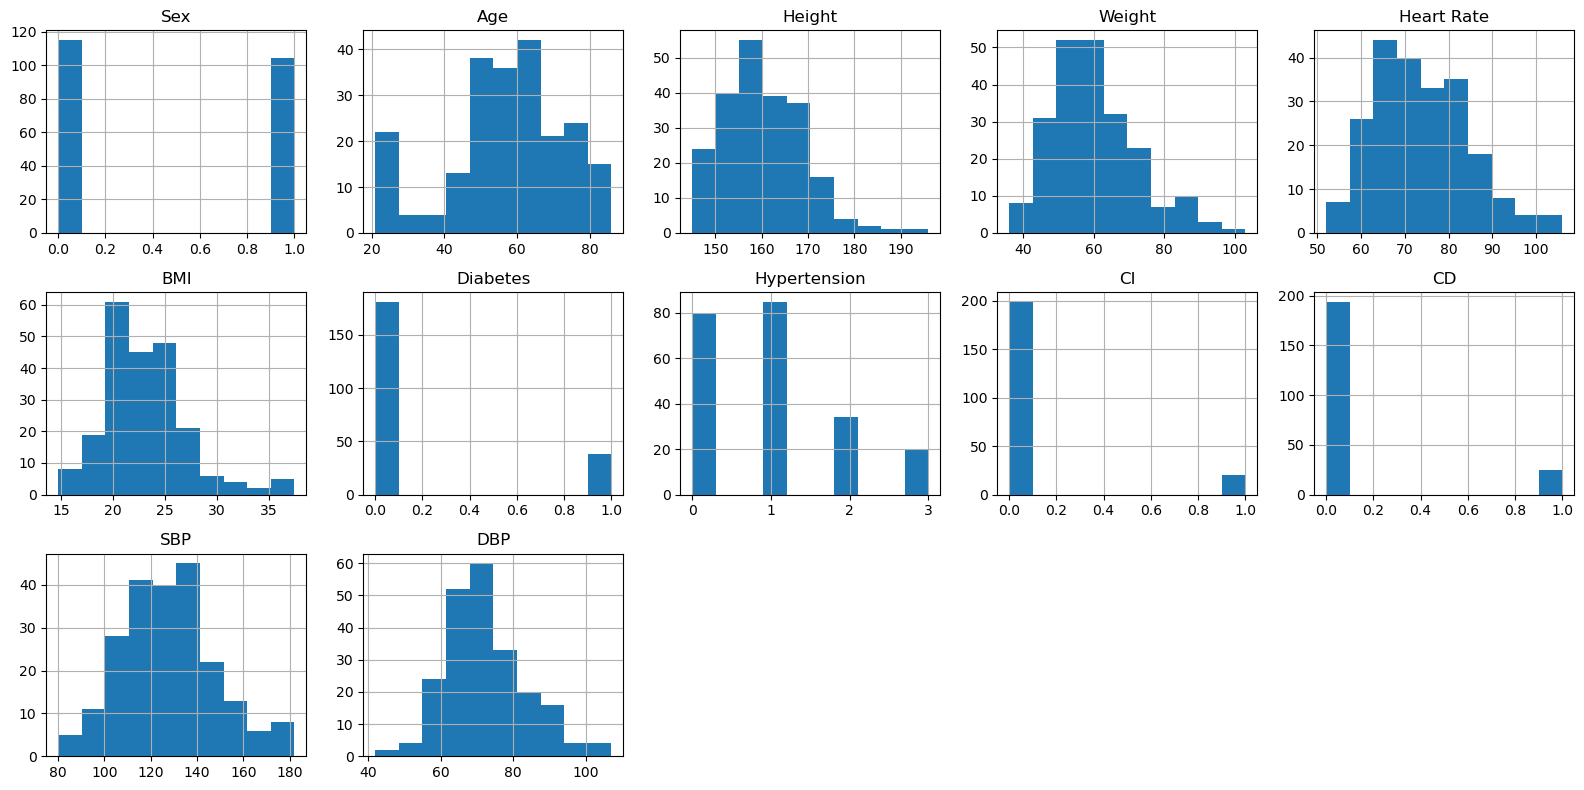

In [7]:
# Kiểm tra phân bố của các thuộc tính
plt.figure(figsize=(16, 8))
for i, col in enumerate(df.columns):
    plt.subplot(3, 5, i+1)
    df[col].hist()
    plt.title(col)
plt.tight_layout()
plt.show()

In [8]:
import plotly.graph_objects as go

corr_matrix = df.corr()

fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='YlOrRd',
                   text=corr_matrix.values, # hiển thị giá trị tương quan
                   #texttemplate='%.2f' # định dạng giá trị tương quan với 2 chữ số thập phân
))

fig.update_traces(hoverinfo='text+z') # hiển thị giá trị tương quan khi di chuột qua
fig.update_layout(title='Correlation Matrix',
                 width=1000,
                 height=800)
fig.show()

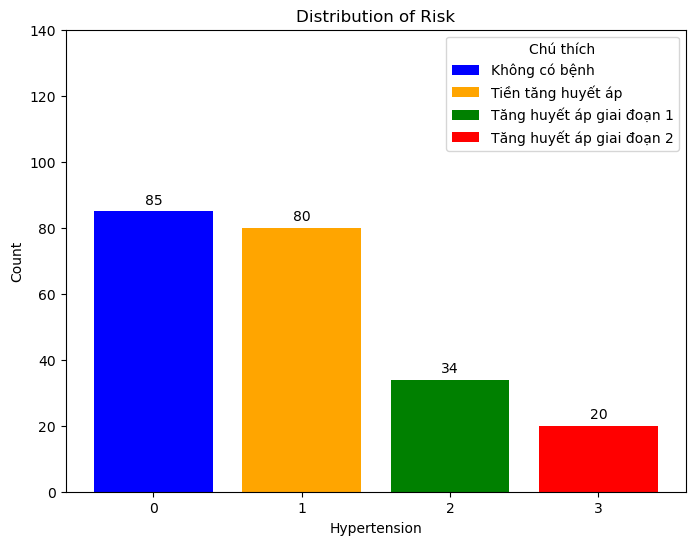

In [9]:
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']
bars = plt.bar(range(4), df['Hypertension'].value_counts(), width=0.8, color=colors)
plt.xticks(range(4), ['0', '1', '2', '3'])
plt.title('Distribution of Risk')
plt.xlabel('Hypertension')
plt.ylabel('Count')
plt.ylim(0, 140)

# Tạo các handles cho legend
handles = bars
labels = ['Không có bệnh', 'Tiền tăng huyết áp', 'Tăng huyết áp giai đoạn 1', 'Tăng huyết áp giai đoạn 2']

plt.legend(handles, labels, title='Chú thích', loc='upper right')
plt.bar_label(bars, padding=3, fontsize=10)
plt.show()

In [10]:
# Phân tích mối quan hệ giữa các thuộc tính và biến mục tiêu
#plt.figure(figsize=(16, 8))
#for i, col in enumerate(df.columns[:-1]):
    #plt.subplot(3, 5, i+1)
    #sns.scatterplot(x=col, y='Risk', data=df)
    #plt.title(col)
#plt.tight_layout()
#plt.show()


In [11]:
# Tạo biến nhị phân (dummy variables) cho các feature định tính
columns_to_get_dummies = ['Sex', 'Diabetes', 'CI', 'CD']
data = pd.get_dummies(df, columns=columns_to_get_dummies).drop(['Sex_0', 'Diabetes_0', 'CI_0', 'CD_0'], axis=1)

# Chuẩn hóa (standardize) các feature định lượng
standardScaler = StandardScaler()
columns_to_scale = ['Age', 'Height', 'Weight', 'SBP', 'DBP', 'Heart Rate', 'BMI']
data[columns_to_scale] = standardScaler.fit_transform(data[columns_to_scale])

In [12]:
print (data)#.astype(int))

          Age    Height    Weight  Heart Rate       BMI  Hypertension  \
0   -0.768337 -1.127587  0.236798    2.180326  1.041372             3   
1   -0.452641 -0.516648 -0.859404    0.220334 -0.706481             3   
2   -0.642058 -1.371963 -1.112373    0.500333 -0.555281             0   
3   -0.768337  1.316169  0.405444    1.246997 -0.284352             1   
4   -0.705198 -0.761024  0.405444   -0.059665  0.988096             1   
..        ...       ...       ...         ...       ...           ...   
214 -2.094258  2.293672  0.827060    0.313667 -0.376059             0   
215 -2.031119 -0.638836 -1.112373    0.500333 -0.949728             0   
216 -2.031119  1.804921 -0.437788   -0.152998 -1.339503             1   
217 -2.031119  1.438357  0.236798   -0.619663 -0.515002             0   
218 -2.094258  1.682733 -0.184818   -0.806329 -1.043382             0   

          SBP       DBP  Sex_1  Diabetes_1   CI_1   CD_1  
0    1.625816  1.547085  False       False  False  False  
1    

In [13]:

#X = result.to_numpy()
  

# Chia thành tập huấn luyện và tập kiểm tra
data_row_dim = 1
data_col_dim = 12
X = data.drop(['Hypertension'], axis = 1).to_numpy()
print(X.shape)
#X = X.values.reshape(-1, data_row_dim, data_col_dim)
#print(X.shape)   
y_temp = data['Hypertension']
# Chuyển đổi kiểu dữ liệu của y thành số thực
y = y_temp.dropna().astype('float32').to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#X_train = X_train.reshape(X_train.shape[0],data_row_dim,data_col_dim,1)
#X_test = X_test.reshape(X_test.shape[0],data_row_dim,data_col_dim,1)
input_shape = (data_row_dim,data_col_dim,1)

print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#print('X_train.shape', X_test.shape)
print(X_train.shape[0],'Train Sample')
print(X_test.shape[0],'Test Sample')



(219, 11)
(153, 11) (153,)
(66, 11) (66,)
(153, 11) (153,)
(66, 11) (66,)
153 Train Sample
66 Test Sample


In [14]:
#Tạo Model

model = Sequential()
model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=32,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=16,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=8,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile( loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"]) # categorical_crossentropy'
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

# Model training
#history = model.fit(X_train,y_train , batch_size=128,epochs=100,verbose=1,validation_data=(X_test,y_test))
history= model.fit(X_train,y_train , batch_size=128,epochs=700,verbose=1,validation_data=(X_test,y_test))

#model.fit(X_train,y_train, batch_size=128, validation_data=(X_test,y_test), epochs=40, verbose=1)
print("The Model has Successfully Trained")


Epoch 1/700
2/2 [==============================] - 1s 244ms/step - loss: 1.4651 - accuracy: 0.2026 - val_loss: 1.3826 - val_accuracy: 0.1970
Epoch 2/700
2/2 [==============================] - 0s 30ms/step - loss: 1.4287 - accuracy: 0.2157 - val_loss: 1.3729 - val_accuracy: 0.2273
Epoch 3/700
2/2 [==============================] - 0s 30ms/step - loss: 1.4032 - accuracy: 0.2614 - val_loss: 1.3652 - val_accuracy: 0.3333
Epoch 4/700
2/2 [==============================] - 0s 28ms/step - loss: 1.3979 - accuracy: 0.2222 - val_loss: 1.3595 - val_accuracy: 0.4242
Epoch 5/700
2/2 [==============================] - 0s 28ms/step - loss: 1.3771 - accuracy: 0.3007 - val_loss: 1.3553 - val_accuracy: 0.4697
Epoch 6/700
2/2 [==============================] - 0s 28ms/step - loss: 1.3691 - accuracy: 0.3007 - val_loss: 1.3515 - val_accuracy: 0.3636
Epoch 7/700
2/2 [==============================] - 0s 28ms/step - loss: 1.3593 - accuracy: 0.3203 - val_loss: 1.3481 - val_accuracy: 0.3182
Epoch 8/700
2/2 [==

Epoch 233/700
2/2 [==============================] - 0s 27ms/step - loss: 0.6410 - accuracy: 0.7190 - val_loss: 0.5040 - val_accuracy: 0.7879
Epoch 234/700
2/2 [==============================] - 0s 27ms/step - loss: 0.4510 - accuracy: 0.8235 - val_loss: 0.5100 - val_accuracy: 0.8030
Epoch 235/700
2/2 [==============================] - 0s 28ms/step - loss: 0.5333 - accuracy: 0.7843 - val_loss: 0.5152 - val_accuracy: 0.8030
Epoch 236/700
2/2 [==============================] - 0s 27ms/step - loss: 0.5814 - accuracy: 0.7712 - val_loss: 0.5172 - val_accuracy: 0.8030
Epoch 237/700
2/2 [==============================] - 0s 29ms/step - loss: 0.5975 - accuracy: 0.7255 - val_loss: 0.5199 - val_accuracy: 0.7727
Epoch 238/700
2/2 [==============================] - 0s 28ms/step - loss: 0.6830 - accuracy: 0.7582 - val_loss: 0.5196 - val_accuracy: 0.7727
Epoch 239/700
2/2 [==============================] - 0s 28ms/step - loss: 0.5180 - accuracy: 0.7647 - val_loss: 0.5158 - val_accuracy: 0.7727
Epoch 

Epoch 291/700
2/2 [==============================] - 0s 27ms/step - loss: 0.4962 - accuracy: 0.7843 - val_loss: 0.4363 - val_accuracy: 0.7879
Epoch 292/700
2/2 [==============================] - 0s 27ms/step - loss: 0.4716 - accuracy: 0.8366 - val_loss: 0.4349 - val_accuracy: 0.7879
Epoch 293/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4476 - accuracy: 0.8170 - val_loss: 0.4325 - val_accuracy: 0.7879
Epoch 294/700
2/2 [==============================] - 0s 28ms/step - loss: 0.6232 - accuracy: 0.7582 - val_loss: 0.4336 - val_accuracy: 0.8030
Epoch 295/700
2/2 [==============================] - 0s 27ms/step - loss: 0.4590 - accuracy: 0.8105 - val_loss: 0.4371 - val_accuracy: 0.8030
Epoch 296/700
2/2 [==============================] - 0s 27ms/step - loss: 0.5069 - accuracy: 0.7908 - val_loss: 0.4393 - val_accuracy: 0.8030
Epoch 297/700
2/2 [==============================] - 0s 27ms/step - loss: 0.4893 - accuracy: 0.7908 - val_loss: 0.4417 - val_accuracy: 0.8030
Epoch 

Epoch 349/700
2/2 [==============================] - 0s 30ms/step - loss: 0.4158 - accuracy: 0.8235 - val_loss: 0.4429 - val_accuracy: 0.7879
Epoch 350/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4857 - accuracy: 0.8039 - val_loss: 0.4403 - val_accuracy: 0.7879
Epoch 351/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4554 - accuracy: 0.8301 - val_loss: 0.4373 - val_accuracy: 0.7879
Epoch 352/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4481 - accuracy: 0.8105 - val_loss: 0.4359 - val_accuracy: 0.7879
Epoch 353/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4881 - accuracy: 0.7778 - val_loss: 0.4366 - val_accuracy: 0.7879
Epoch 354/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4906 - accuracy: 0.7908 - val_loss: 0.4358 - val_accuracy: 0.7879
Epoch 355/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4324 - accuracy: 0.7908 - val_loss: 0.4365 - val_accuracy: 0.7879
Epoch 

Epoch 407/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3983 - accuracy: 0.8431 - val_loss: 0.3924 - val_accuracy: 0.8030
Epoch 408/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4235 - accuracy: 0.8105 - val_loss: 0.3974 - val_accuracy: 0.7879
Epoch 409/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3718 - accuracy: 0.8497 - val_loss: 0.4016 - val_accuracy: 0.7879
Epoch 410/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3409 - accuracy: 0.8758 - val_loss: 0.4055 - val_accuracy: 0.7879
Epoch 411/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3600 - accuracy: 0.8431 - val_loss: 0.4048 - val_accuracy: 0.7879
Epoch 412/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4222 - accuracy: 0.8235 - val_loss: 0.4036 - val_accuracy: 0.7879
Epoch 413/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3448 - accuracy: 0.8431 - val_loss: 0.4003 - val_accuracy: 0.7879
Epoch 

Epoch 465/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4950 - accuracy: 0.7778 - val_loss: 0.3524 - val_accuracy: 0.8333
Epoch 466/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3654 - accuracy: 0.8366 - val_loss: 0.3498 - val_accuracy: 0.8333
Epoch 467/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3931 - accuracy: 0.8235 - val_loss: 0.3483 - val_accuracy: 0.8333
Epoch 468/700
2/2 [==============================] - 0s 29ms/step - loss: 0.3580 - accuracy: 0.8366 - val_loss: 0.3467 - val_accuracy: 0.8485
Epoch 469/700
2/2 [==============================] - 0s 29ms/step - loss: 0.4029 - accuracy: 0.8497 - val_loss: 0.3449 - val_accuracy: 0.8485
Epoch 470/700
2/2 [==============================] - 0s 29ms/step - loss: 0.3792 - accuracy: 0.8301 - val_loss: 0.3441 - val_accuracy: 0.8485
Epoch 471/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3084 - accuracy: 0.8693 - val_loss: 0.3443 - val_accuracy: 0.8485
Epoch 

Epoch 523/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3880 - accuracy: 0.8366 - val_loss: 0.3968 - val_accuracy: 0.8030
Epoch 524/700
2/2 [==============================] - 0s 29ms/step - loss: 0.3809 - accuracy: 0.8627 - val_loss: 0.3968 - val_accuracy: 0.8030
Epoch 525/700
2/2 [==============================] - 0s 29ms/step - loss: 0.3629 - accuracy: 0.8627 - val_loss: 0.3987 - val_accuracy: 0.8030
Epoch 526/700
2/2 [==============================] - 0s 28ms/step - loss: 0.4142 - accuracy: 0.7778 - val_loss: 0.4014 - val_accuracy: 0.8182
Epoch 527/700
2/2 [==============================] - 0s 31ms/step - loss: 0.4190 - accuracy: 0.8105 - val_loss: 0.4049 - val_accuracy: 0.8182
Epoch 528/700
2/2 [==============================] - 0s 30ms/step - loss: 0.2691 - accuracy: 0.8824 - val_loss: 0.4060 - val_accuracy: 0.8182
Epoch 529/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3705 - accuracy: 0.8562 - val_loss: 0.4076 - val_accuracy: 0.8030
Epoch 

Epoch 581/700
2/2 [==============================] - 0s 28ms/step - loss: 0.3014 - accuracy: 0.8889 - val_loss: 0.3596 - val_accuracy: 0.8485
Epoch 582/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3246 - accuracy: 0.8824 - val_loss: 0.3669 - val_accuracy: 0.8485
Epoch 583/700
2/2 [==============================] - 0s 29ms/step - loss: 0.3232 - accuracy: 0.8627 - val_loss: 0.3732 - val_accuracy: 0.8485
Epoch 584/700
2/2 [==============================] - 0s 30ms/step - loss: 0.4145 - accuracy: 0.8497 - val_loss: 0.3792 - val_accuracy: 0.8485
Epoch 585/700
2/2 [==============================] - 0s 30ms/step - loss: 0.2277 - accuracy: 0.9216 - val_loss: 0.3823 - val_accuracy: 0.8485
Epoch 586/700
2/2 [==============================] - 0s 27ms/step - loss: 0.3337 - accuracy: 0.8431 - val_loss: 0.3848 - val_accuracy: 0.8485
Epoch 587/700
2/2 [==============================] - 0s 31ms/step - loss: 0.3656 - accuracy: 0.8366 - val_loss: 0.3843 - val_accuracy: 0.8636
Epoch 

Epoch 639/700
2/2 [==============================] - 0s 31ms/step - loss: 0.2226 - accuracy: 0.8889 - val_loss: 0.2464 - val_accuracy: 0.8939
Epoch 640/700
2/2 [==============================] - 0s 34ms/step - loss: 0.3087 - accuracy: 0.8562 - val_loss: 0.2487 - val_accuracy: 0.8939
Epoch 641/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3542 - accuracy: 0.8497 - val_loss: 0.2533 - val_accuracy: 0.8939
Epoch 642/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3213 - accuracy: 0.8954 - val_loss: 0.2599 - val_accuracy: 0.8939
Epoch 643/700
2/2 [==============================] - 0s 30ms/step - loss: 0.3787 - accuracy: 0.8431 - val_loss: 0.2686 - val_accuracy: 0.8939
Epoch 644/700
2/2 [==============================] - 0s 30ms/step - loss: 0.2841 - accuracy: 0.8824 - val_loss: 0.2798 - val_accuracy: 0.8939
Epoch 645/700
2/2 [==============================] - 0s 32ms/step - loss: 0.2638 - accuracy: 0.9150 - val_loss: 0.2855 - val_accuracy: 0.8939
Epoch 

Epoch 697/700
2/2 [==============================] - 0s 31ms/step - loss: 0.2965 - accuracy: 0.9020 - val_loss: 0.3379 - val_accuracy: 0.8939
Epoch 698/700
2/2 [==============================] - 0s 31ms/step - loss: 0.2215 - accuracy: 0.9281 - val_loss: 0.3322 - val_accuracy: 0.8939
Epoch 699/700
2/2 [==============================] - 0s 33ms/step - loss: 0.3319 - accuracy: 0.8758 - val_loss: 0.3291 - val_accuracy: 0.8939
Epoch 700/700
2/2 [==============================] - 0s 32ms/step - loss: 0.2155 - accuracy: 0.9216 - val_loss: 0.3268 - val_accuracy: 0.8939
The Model has Successfully Trained


In [15]:
#y_test = pd.DataFrame(y_test)
y_test

array([2., 1., 0., 2., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 1., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 2., 2., 1., 1., 2., 1., 0., 3., 1.,
       1., 3., 1., 0., 2., 0., 0., 0., 3., 0., 1., 1., 1., 1., 0., 3., 1.,
       2., 1., 1., 0., 1., 1., 2., 1., 0., 2., 1., 0., 0., 1., 3.],
      dtype=float32)

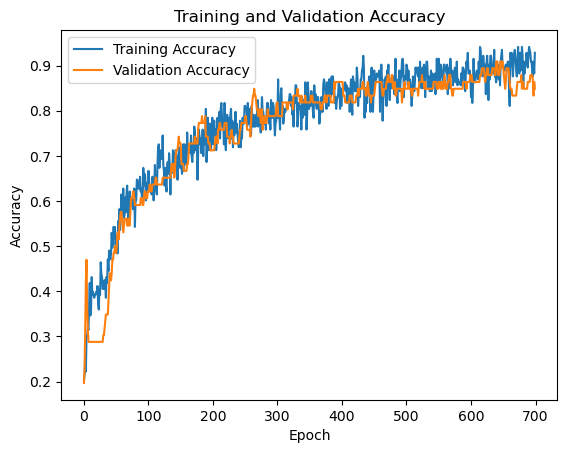

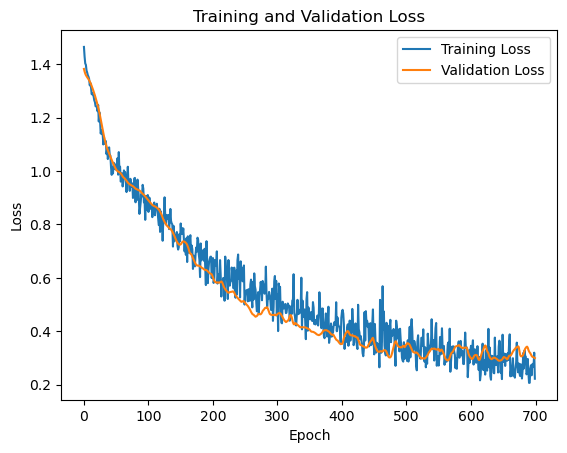

In [16]:
import matplotlib.pyplot as plt

# Lấy thông tin độ chính xác và mất mát từ lịch sử
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ độ chính xác
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Vẽ biểu đồ mất mát
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
predictions = model.predict(X_test)
predictions

3/3 [==============================] - 0s 3ms/step


array([[2.3561874e-03, 4.1365251e-01, 5.3119916e-01, 5.2792151e-02],
       [6.1611780e-03, 9.7612339e-01, 1.6952680e-02, 7.6264731e-04],
       [9.9999994e-01, 1.3013673e-09, 0.0000000e+00, 0.0000000e+00],
       [4.7963770e-04, 1.3305779e-01, 7.6946133e-01, 9.7001120e-02],
       [5.7415357e-03, 9.8937839e-01, 4.7432608e-03, 1.3652704e-04],
       [5.1141375e-01, 4.8857790e-01, 8.1997105e-06, 2.0347539e-07],
       [4.2830713e-02, 9.5702660e-01, 1.4000687e-04, 2.5712748e-06],
       [9.8971367e-01, 1.0286300e-02, 4.0698845e-18, 1.0669036e-22],
       [7.8645892e-02, 9.2069381e-01, 6.3667668e-04, 2.3590728e-05],
       [5.1483819e-03, 8.4072733e-01, 1.4190316e-01, 1.2221053e-02],
       [8.9239632e-04, 1.6607474e-01, 7.2626561e-01, 1.0676720e-01],
       [7.0581716e-03, 9.8136520e-01, 1.1121374e-02, 4.5523871e-04],
       [2.3786264e-05, 1.5091213e-02, 4.0853798e-01, 5.7634699e-01],
       [5.4033757e-03, 9.0625453e-01, 8.1950136e-02, 6.3919467e-03],
       [5.2695423e-03, 9.8895276e-

In [18]:
y_pred = tf.argmax(predictions, axis=-1)
#y_pred = tf.greater(predictions, .5)
y_pred

<tf.Tensor: shape=(66,), dtype=int64, numpy=
array([2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 3, 1, 1, 0, 0, 2, 0, 2, 0, 0,
       1, 0, 0, 2, 2, 1, 1, 2, 1, 0, 3, 1, 1, 2, 1, 0, 2, 0, 0, 0, 3, 0,
       1, 1, 1, 1, 0, 3, 1, 2, 1, 0, 0, 1, 1, 3, 1, 0, 3, 1, 0, 0, 1, 2],
      dtype=int64)>

In [19]:
y_test

array([2., 1., 0., 2., 1., 1., 1., 1., 1., 1., 2., 1., 2., 2., 1., 0., 0.,
       2., 0., 1., 0., 0., 1., 0., 0., 2., 2., 1., 1., 2., 1., 0., 3., 1.,
       1., 3., 1., 0., 2., 0., 0., 0., 3., 0., 1., 1., 1., 1., 0., 3., 1.,
       2., 1., 1., 0., 1., 1., 2., 1., 0., 2., 1., 0., 0., 1., 3.],
      dtype=float32)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
cm = confusion_matrix(y_test, y_pred)

In [22]:
print(cm)

[[19  0  0  0]
 [ 3 25  1  0]
 [ 0  1  9  3]
 [ 0  0  2  3]]


In [23]:
# Vẽ ma trận nhầm lẫn
#plt.figure(figsize=(5, 4))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
#plt.title('Confusion Matrix')
#plt.show()

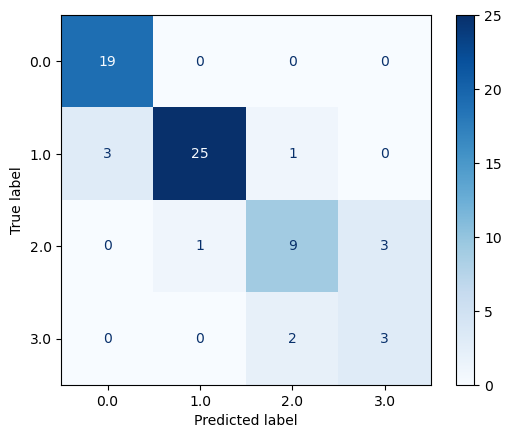

In [24]:
#y_pred = y_pred[:len(y_test)]
# Vẽ confusion matrix với scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Confusion Matrix')
plt.show()

In [25]:
print(classification_report(y_test,y_pred))
#unique_labels = np.unique(np.concatenate([y_test, y_pred]))
#print(confusion_matrix(y_test, y_pred, labels=unique_labels))
#print(classification_report(y_test, y_pred,  zero_division=1))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93        19
         1.0       0.96      0.86      0.91        29
         2.0       0.75      0.69      0.72        13
         3.0       0.50      0.60      0.55         5

    accuracy                           0.85        66
   macro avg       0.77      0.79      0.78        66
weighted avg       0.86      0.85      0.85        66



In [26]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Giả sử predictions là kết quả dự đoán từ mô hình
y_true = label_binarize(y_test, classes=[0, 1, 2, 3])  # Chuyển đổi nhãn thực tế thành nhị phân
n_classes = y_true.shape[1]

# Tính y_scores cho từng lớp
y_scores = predictions  # Đầu ra của mô hình (xác suất cho từng lớp)

# Tính TPR và FPR cho từng lớp
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [27]:
print('True Positive Rate:')
print(tpr)
print('False Positive Rate:')
print(fpr)

True Positive Rate:
{0: array([0.        , 0.42105263, 0.89473684, 0.89473684, 0.94736842,
       0.94736842, 1.        , 1.        ]), 1: array([0.        , 0.03448276, 0.79310345, 0.79310345, 0.89655172,
       0.89655172, 0.93103448, 0.93103448, 0.96551724, 0.96551724,
       1.        , 1.        ]), 2: array([0.        , 0.07692308, 0.61538462, 0.61538462, 0.69230769,
       0.69230769, 0.76923077, 0.76923077, 0.92307692, 0.92307692,
       1.        , 1.        , 1.        ]), 3: array([0. , 0.2, 0.4, 0.4, 0.6, 0.6, 1. , 1. , 1. ])}
False Positive Rate:
{0: array([0.        , 0.        , 0.        , 0.0212766 , 0.0212766 ,
       0.04255319, 0.04255319, 1.        ]), 1: array([0.        , 0.        , 0.        , 0.02702703, 0.02702703,
       0.05405405, 0.05405405, 0.10810811, 0.10810811, 0.45945946,
       0.45945946, 1.        ]), 2: array([0.        , 0.        , 0.        , 0.01886792, 0.01886792,
       0.05660377, 0.05660377, 0.0754717 , 0.0754717 , 0.09433962,
       0.09

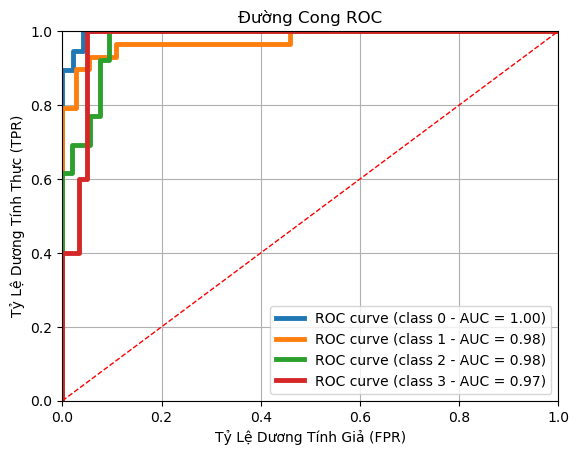

In [28]:
# Vẽ đường ROC cho từng lớp
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i} - AUC = {roc_auc[i]:.2f})', linewidth=3.5)  # Chỉ sử dụng linewidth

plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1)  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tỷ Lệ Dương Tính Giả (FPR)')
plt.ylabel('Tỷ Lệ Dương Tính Thực (TPR)')
plt.title('Đường Cong ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [30]:
import numpy as np

# Dự đoán xác suất trên tập kiểm tra
probabilities = model.predict(X_test)

# In hệ số tin cậy cho từng mẫu và lớp dự đoán
for i, probs in enumerate(probabilities):
    predicted_class = np.argmax(probs)
    print(f'Mẫu {i + 1}: Hệ số tin cậy = {probs}, Lớp dự đoán = {predicted_class}')

3/3 [==============================] - 0s 1ms/step
Mẫu 1: Hệ số tin cậy = [0.00235619 0.4136525  0.53119916 0.05279215], Lớp dự đoán = 2
Mẫu 2: Hệ số tin cậy = [6.161178e-03 9.761234e-01 1.695268e-02 7.626473e-04], Lớp dự đoán = 1
Mẫu 3: Hệ số tin cậy = [9.9999994e-01 1.3013673e-09 0.0000000e+00 0.0000000e+00], Lớp dự đoán = 0
Mẫu 4: Hệ số tin cậy = [4.7963770e-04 1.3305779e-01 7.6946133e-01 9.7001120e-02], Lớp dự đoán = 2
Mẫu 5: Hệ số tin cậy = [5.7415357e-03 9.8937839e-01 4.7432608e-03 1.3652704e-04], Lớp dự đoán = 1
Mẫu 6: Hệ số tin cậy = [5.1141375e-01 4.8857790e-01 8.1997105e-06 2.0347539e-07], Lớp dự đoán = 0
Mẫu 7: Hệ số tin cậy = [4.2830713e-02 9.5702660e-01 1.4000687e-04 2.5712748e-06], Lớp dự đoán = 1
Mẫu 8: Hệ số tin cậy = [9.8971367e-01 1.0286300e-02 4.0698845e-18 1.0669036e-22], Lớp dự đoán = 0
Mẫu 9: Hệ số tin cậy = [7.8645892e-02 9.2069381e-01 6.3667668e-04 2.3590728e-05], Lớp dự đoán = 1
Mẫu 10: Hệ số tin cậy = [0.00514838 0.8407273  0.14190316 0.01222105], Lớp dự đoán 